In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML
from datetime import datetime, date, timedelta
import urllib.request
import shutil
import os.path
# pd.set_option('display.max_rows', 100)
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.animation as animation
from IPython.display import HTML

In [93]:
def downloadCovidData(today):
    if today:
        todays_date = datetime.strftime(datetime.now(), '%d-%B-%Y')
    else:
        todays_date = datetime.strftime(datetime.now() - timedelta(1), '%d-%B-%Y')
    url = 'https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2020/04/COVID-19-total-announced-deaths-' + todays_date + '.xlsx'
    file_name = 'COVID-19-total-announced-deaths-' + todays_date + '.xlsx'
    file_name_str = str(file_name)
    print(file_name_str)
    
    if os.path.isfile(file_name) is not True:
        try:
            # Download the file from `url` and save it locally under `file_name`:
            with urllib.request.urlopen(url) as response, open(file_name, 'wb') as file_name:
                shutil.copyfileobj(response, file_name)
            print('New File downloaded.')
            return file_name_str
        except:
            print('Please download the latest covid data directly from the NHS statistics page')
    else:
        print('File already exists.')
        return file_name_str
    
file_name = downloadCovidData(today=True)

COVID-19-total-announced-deaths-13-April-2020.xlsx
New File downloaded.


In [94]:
df = pd.read_excel(file_name,
                  sheet_name='COVID19 total deaths by trust',
                  header=15, 
                  index_col=[0]
                  )
df.drop(df.filter(regex="Unname"),axis=1, inplace=True)
df = df.iloc[2:]
df.drop(['Code', 'Name', 'Awaiting verification', 'Total'], axis=1,inplace=True)
df.rename(columns={'NHS England Region': 'NHS_England_Region'}, inplace=True)
df = pd.melt(df, id_vars=['NHS_England_Region'], var_name='Date', value_name='Deaths')
df = df[df['Date'] != 'Up to 01-Mar-20']
df['Date'] =pd.to_datetime(df.Date)

In [95]:
dft = df.copy()
dft2 = dft.groupby(['NHS_England_Region', 'Date'], as_index=False).Deaths.sum()
dft2['cumsum'] = dft2.groupby(['NHS_England_Region'])['Deaths'].transform(pd.Series.cumsum)
dft2

,NHS_England_Region,Date,Deaths,cumsum
0,East Of England,2020-03-01,0.0,0.0
1,East Of England,2020-03-02,0.0,0.0
2,East Of England,2020-03-03,3.0,3.0
3,East Of England,2020-03-04,1.0,4.0
4,East Of England,2020-03-05,0.0,4.0
...,...,...,...,...
339,South West,2020-04-08,42.0,411.0
340,South West,2020-04-09,16.0,427.0
341,South West,2020-04-10,33.0,460.0
342,South West,2020-04-11,33.0,493.0


In [96]:
dft2.Date.max()

Timestamp('2020-04-12 00:00:00')

In [97]:
dft2.drop(['Deaths'], axis=1,inplace=True)
dft2.rename(columns={'cumsum': 'Deaths'}, inplace=True)

In [98]:
df['cumsum'] = df.groupby(['NHS_England_Region','Date'])['Deaths'].transform(pd.Series.cumsum)
df.drop('Deaths', axis=1, inplace=True)
df = df.groupby(['NHS_England_Region','Date'], as_index=False)['cumsum'].max()

In [99]:
df.head()

,NHS_England_Region,Date,cumsum
0,East Of England,2020-03-01,0.0
1,East Of England,2020-03-02,0.0
2,East Of England,2020-03-03,3.0
3,East Of England,2020-03-04,1.0
4,East Of England,2020-03-05,0.0


<BarContainer object of 344 artists>

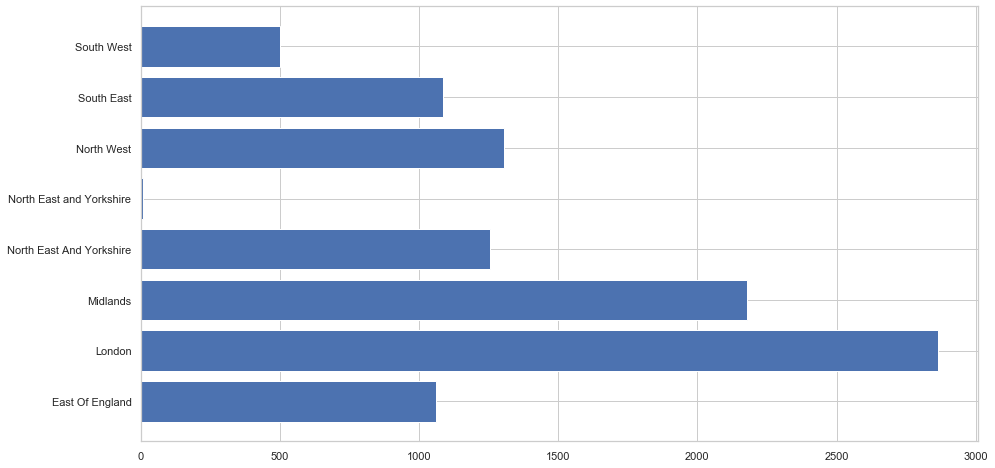

In [100]:
fig, ax = plt.subplots(figsize=(15,8))
ax.barh(dft2['NHS_England_Region'], dft2.Deaths)

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

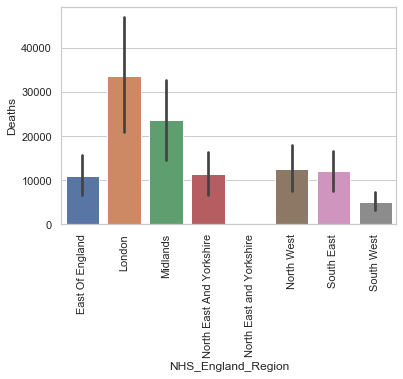

In [101]:
sns.barplot(x='NHS_England_Region', y="Deaths", data=dft2, estimator=sum)
plt.xticks(rotation=90)

In [102]:
colors = dict(zip(
    ['London', 'Midlands', 'North East And Yorkshire', 'South East',
     'East Of England', 'North West', 'South West', 'North East and Yorkshire'],
    ['#adb0ff', '#ffb3ff', '#90d595', '#e48381',
     '#aafbff', '#f7bb5f', '#eafb50','#90d595']
))

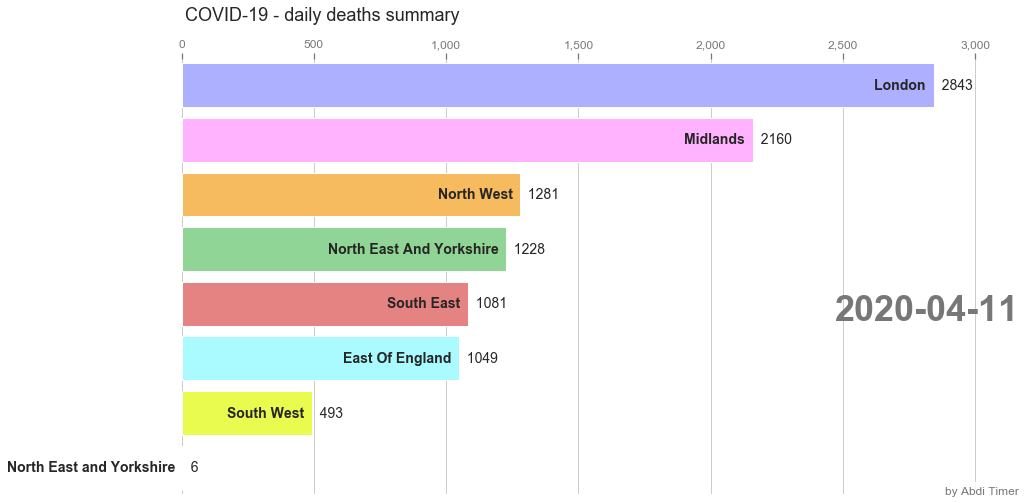

In [165]:
fig, ax = plt.subplots(figsize=(15, 8))

def bar_chart_race(fulldate):
    dff = dft2[dft2['Date'] == fulldate].sort_values(by='Deaths', ascending=True).tail(10)
    ax.clear()
    ax.barh(dff['NHS_England_Region'], dff['Deaths'], color=[colors[x] for x in dff['NHS_England_Region']])
    
    ax.set_xlim(0, dft2.Deaths.max()+300)
    
    dx = dff['Deaths'].max()
    
    for i, (value, name) in enumerate(zip(dff['Deaths'], dff['NHS_England_Region'])):
        ax.text(value, i, name+'  ', size=14, weight=600, ha='right', va='center') 
        ax.text(value, i, '  '+ str(int(value)), size=14, ha='left',  va='center')  

    # ... polished styles
    ax.text(1, 0.4, fulldate, transform=ax.transAxes, color='#777777', size=36, ha='right',  weight=800)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    
    ax.text(0, 1.15, '',
            transform=ax.transAxes, size=24, weight=500, ha='left', va='center')
    
    ax.text(0.004, 1.10, 'COVID-19 - daily deaths summary',
            transform=ax.transAxes, size=18, weight=500, ha='left', va='center')
    
    ax.text(1, 0, 'by Abdi Timer', transform=ax.transAxes, ha='right',
            color='#777777', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    plt.box(False)

current_date = '2020-04-11'    
bar_chart_race(current_date)

In [111]:
start_date = date(2020,3,1)   
end_date = date(2020, datetime.now().month, datetime.now().day - 1)   
# this will give you a list containing all of the dates
dd = [start_date + timedelta(days=x) for x in range((end_date-start_date).days + 1)]
datesfrom = [date_obj.strftime('%Y-%m-%d') for date_obj in dd]

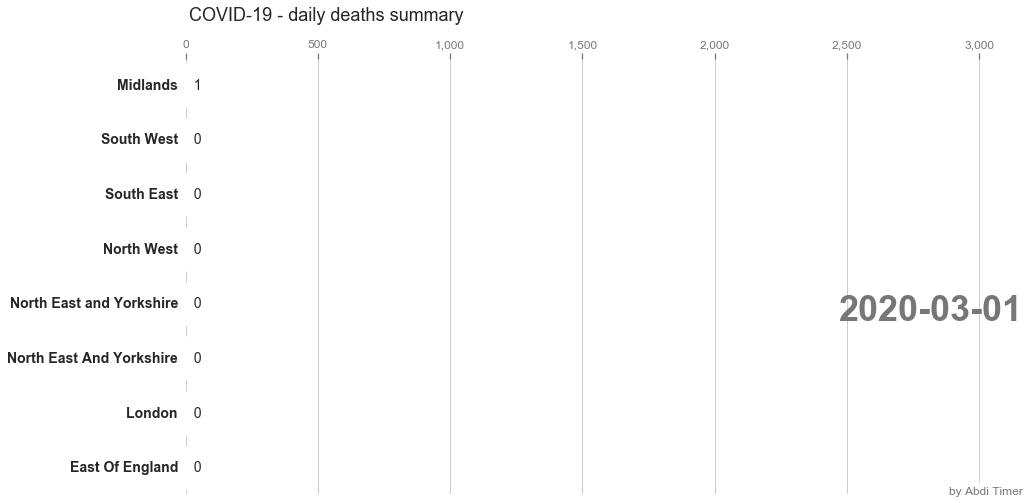

In [166]:
fig, ax = plt.subplots(figsize=(15, 8))
animator = animation.FuncAnimation(fig, bar_chart_race, frames=datesfrom)
HTML(animator.to_jshtml()) 